In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit
import torch

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

import utils.torchUtils as gnn

In [2]:
# signaltrees = ObjIter([Tree(fc.eightb.preselection.signal_list[i]) for i in (0,4,7)])
signaltrees = ObjIter([Tree(fc.eightb.preselection.signal_list[i]) for i in (6,)])

In [3]:
signaltrees.apply(lambda t:build_all_dijets(t))

[None]

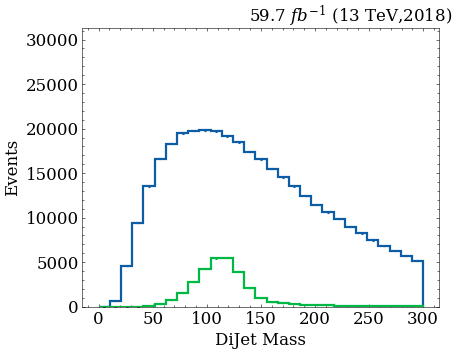

In [7]:
study.quick(
    signaltrees[[0,0]],
    masks=[lambda t:t.dijet_signalId == -1, lambda t:t.dijet_signalId>-1],
    varlist=['dijet_m']
)

In [11]:
ak.mean(signaltrees.apply(lambda t:t.dijet_m[t.dijet_signalId>-1]).awk)

118.62646361065883

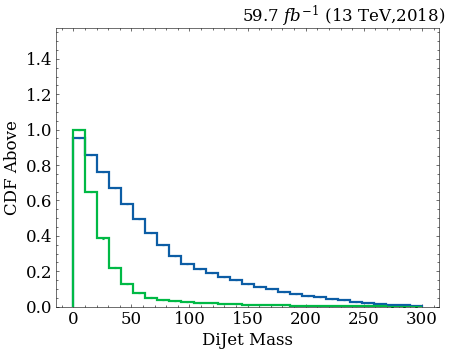

In [17]:
def offset(v):
    return np.abs(v-118.626)
study.quick(
    signaltrees[[0,0]],
    transforms=offset,
    masks=[lambda t:t.dijet_signalId == -1, lambda t:t.dijet_signalId>-1],
    varlist=['dijet_m'],
    
    cumulative=-1,
)

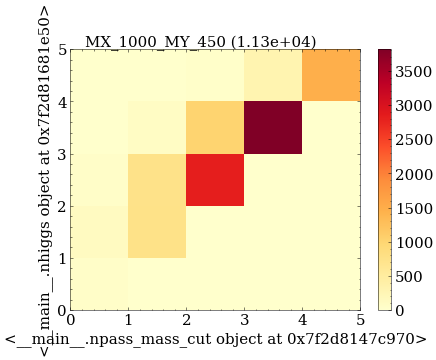

In [45]:
class npass_mass_cut(ObjTransform):
    def __call__(self,tree):
        m = np.abs(tree.dijet_m[tree.dijet_signalId>-1]-self.off)
        npass = ak.sum( m<self.cut,axis=-1 )
        return npass
class nhiggs:
    def __call__(self, tree):
        nhiggs = ak.sum(tree.dijet_signalId>-1, axis=-1)
        return nhiggs

study.quick2d(
    signaltrees[[0]],
    varlist=[npass_mass_cut(off=118.626, cut=50), nhiggs()],
    # cumulative=-1,
)

In [6]:
for tree in signaltrees: tree.color=None

In [5]:
gnn.config.set_gpu(False)

In [6]:
model_paths = [
    # "/uscms_data/d3/ekoenig/8BAnalysis/studies/sixbStudies/jupyter/eightb/graph_net/models/golden_pair/lightning_logs/version_2/checkpoints/epoch=20-step=7538.ckpt",
    # "/uscms_data/d3/ekoenig/8BAnalysis/studies/sixbStudies/jupyter/eightb/graph_net/models/golden_pair/lightning_logs/version_3/checkpoints/epoch=21-step=7897.ckpt",
    "/uscms_data/d3/ekoenig/8BAnalysis/studies/sixbStudies/jupyter/eightb/graph_net/models/golden_pair/lightning_logs/version_6/checkpoints/epoch=15-step=7935.ckpt"
]


In [7]:
model = gnn.modelMap['golden_pair'].load_from_checkpoint(model_paths[-1]).to(device=gnn.config.device)

In [8]:
from torch_geometric.data import Data

class predict_data(gnn.BaseTransform):
    def __init__(self, model=model):
        super().__init__()
        self.model = model
    def __call__(self, data : Data) -> Data:
        pairs = torch.LongTensor([ [i,j] for i in range(data.num_nodes) for j in range(i+1, data.num_nodes)])
        def predict_pair(data, pair):
            data = gnn.sample_pair(data, pair)
            return model.predict(data)
        edge_o = torch.Tensor([predict_pair(data, pair) for pair in pairs])
        min_o, max_o = edge_o.min(), edge_o.max()
        data.edge_o = (edge_o-min_o)/(max_o+min_o)
        data.rank_o = data.edge_o.argsort(descending=True).argsort()
        return data

In [9]:
transform = gnn.Transform()
transform.append(gnn.min_edge_neighbor(n_neighbor=model.hparams['n_neighbor'], undirected=True))
template = gnn.Dataset("../data/template",make_template=True, transform=transform)

In [10]:
def get_tree_graph(tree, ver='testing', path='../data'):
    sample = tree.sample
    dataset = gnn.Dataset(f'{path}/{sample}-{ver}', transform=template.transform+predict_data(model)+gnn.to_uptri_graph())
    loader = gnn.DataLoader(dataset, batch_size=50, num_workers=gnn.config.ncpu)
    tree.graphs = loader

def get_qcd_graph(tree, path='../data'):
    get_name = lambda f : f.fname.split('/')[-2]
    dataset = gnn.concat_dataset([f'{path}/{sample}' for sample in map(get_name, tree.filelist)],transform=template.transform+predict_data(model)+gnn.to_uptri_graph())
    loader = gnn.DataLoader(dataset, batch_size=50, num_workers=gnn.config.ncpu)
    tree.graphs = loader

In [11]:
signaltrees.apply(get_tree_graph)
bkgtrees.apply(get_qcd_graph)

[None]

In [12]:
tree = signaltrees[1]

In [13]:
build_all_dijets(tree)

In [14]:
def predict_dataset(dataset):
    score = []
    for i,batch in enumerate(dataset):
        score.append(batch.edge_o)
    score = torch.cat(score).cpu().numpy()
    return score

def predict_tree(tree):
    score = predict_dataset(tree.graphs)
    n_dijets = ak.count(tree.dijet_pt, axis=-1)
    score = ak.unflatten(score, n_dijets)
    tree.extend(dijet_score=score)

In [15]:
predict_tree(tree)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


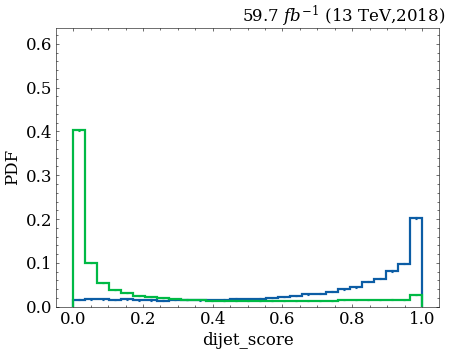

In [16]:
study.quick(
    [tree, tree],
    masks=[lambda t: (t.nfound_presel==8)&(t.dijet_signalId>-1), lambda t:(t.nfound_presel==8)&(t.dijet_signalId==-1)],
    varlist=['dijet_score'],
     density=True,
)

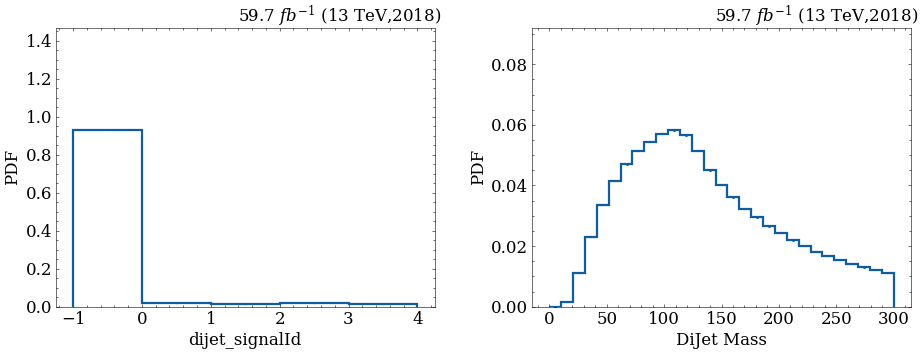

In [17]:
study.quick(
    [tree],
    masks=lambda t:ak.argmax(tree.dijet_score,axis=-1),
    varlist=['dijet_signalId','dijet_m'],
    density=True,
)

In [19]:
select_higgs(tree, 'score', nhiggs=4)

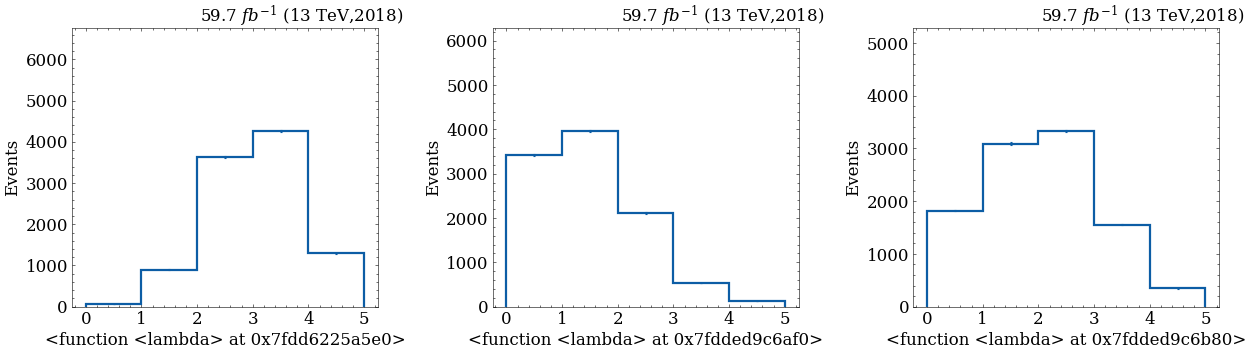

In [20]:
study.quick(
    [tree],
    varlist=[lambda t:ak.sum(t.dijet_signalId>-1, axis=-1),
    lambda t:ak.sum(t.gnn_higgs_signalId>-1, axis=-1),
    lambda t:ak.sum(t.dijet_signalId>-1, axis=-1)-ak.sum(t.gnn_higgs_signalId>-1, axis=-1)],
    dim=(-1,3), 
)